<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/6.9.5.8-paperspace-LSTMB128_dr20_rdr20_batch128_lr01-GloVe_with_stop_nonlemmatized-all-prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trained LSTM on paperspace using entire dataset.

Use this notebook to inspect the report



In [0]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


''

In [0]:
# check what GPU we got
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# check that we are using high RAM runtime
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.
Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, \
    SpatialDropout1D, Flatten, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.initializers import Constant


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight


import pandas as pd
import numpy as np
from IPython.display import SVG
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from datetime import datetime


import util.dict_util as du
import util.plot_util as pu
import util.file_util as fu
import util.keras_util as ku
import util.report_util as ru

import random

# fix random seeds
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(1)
random.seed(1)
np.random.seed(1)

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set()


DATE_FORMAT = '%Y-%m-%d'
TIME_FORMAT = '%Y-%m-%d %H:%M:%S'
LABEL_COLUMN = "star_rating"
FEATURE_COLUMN = "review_body"


# DEBUG = False


# # length of our embedding - 300 is standard
# EMBED_SIZE = 300
# # From EDA, we know that 90% of review bodies have 100 words or less, 
# # we will use this as our sequence length
# MAX_SEQUENCE_LENGTH = 100

# LSTM_DIM = 128 # total LSTM units
# EPOCHS  = 20
# BATCH_SIZE = 128
# LEARNING_RATE = 0.01
# DROPOUT_RATE = 0.2
# RECURRENT_DROPOUT_RATE = 0.2
# PATIENCE = 4
# BIDIRECTIONAL = False
# BALANCE_CLASS_WEIGHTS = True
# TRAIN_EMBEDDINGS = False
# FEATURE_SET_NAME = "glove_with_stop_nonlemmatized"
# SAMPLES = "1m"
# BALANCE_CLASS_WEIGHTS = True
# MODEL_VERSION = 1




# if BIDIRECTIONAL:
#   bidirectional_name = "bi"
# else:
#   bidirectional_name = ""

# if BALANCE_CLASS_WEIGHTS:
#   balanced_name = "B"
# else:
#   balanced_name = ""

# MODEL_NAME = f"{bidirectional_name}LSTM{balanced_name}{LSTM_DIM}"
# ARCHITECTURE = f"1x{LSTM_DIM}"
# DESCRIPTION = f"1 Layer {LSTM_DIM} LSTM Units, Dropout {DROPOUT_RATE}, Recurrent Dropout {RECURRENT_DROPOUT_RATE}, Batch Size {BATCH_SIZE}, Learning Rate {LEARNING_RATE}"

# REPORT_FILE = f"{MODEL_NAME}_" \
#               f"dr{ku.get_decimal_str(DROPOUT_RATE)}_" \
#               f"rdr{ku.get_decimal_str(RECURRENT_DROPOUT_RATE)}_" \
#               f"batch{BATCH_SIZE}_" \
#               f"lr{ku.get_decimal_str(LEARNING_RATE)}-{FEATURE_SET_NAME}-dl_prototype-report.csv"


# if DEBUG:
#   DATA_FILE = f'{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-test-preprocessed.csv'
#   MODEL_NAME = f'test-{MODEL_NAME}'
#   MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-test.csv'
#   ku.ModelWrapper.set_report_filename(f"test-{REPORT_FILE}")

# else:
#   DATA_FILE = f"{DRIVE_DIR}/data/amazon_reviews_us_Wireless_v1_00-{SAMPLES}-with_stop_nonlemmatized-preprocessed.csv"
#   MISSING_WORDS_FILE = f'{DRIVE_DIR}/reports/glove_embedding-missing_words-{SAMPLES}.csv'
#   ku.ModelWrapper.set_report_filename(REPORT_FILE)


# EMBEDDING_FILE = f'{DRIVE_DIR}/data/embeddings/glove.840B.300d.txt'




# start_time = datetime.now()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def set_plt_name(df: pd.DataFrame):
    """
    Set plt_name column based on DF values
    
    DF will be edited in place
    
    :param df: dataframe to add plt_name column to
    :return: df with plt_name added
    """
    df["plt_name"] = df.description.apply(lambda x: x.replace("1 Layer ", ""))
    df["plt_name"] = df.plt_name.apply(lambda x: x.replace("LSTM ", ""))
    df["plt_name"] = df.plt_name.apply(lambda x: x.replace("Recurrent Dropout ", "RDR "))
    df["plt_name"] = df.plt_name.apply(lambda x: x.replace("Dropout ", "DR "))
    df["plt_name"] = df.plt_name.apply(lambda x: x.replace("Batch Size ", "BS "))
    df["plt_name"] = df.plt_name.apply(lambda x: x.replace("Learning Rate ", "LR "))
    
    return df


REPORT_DIR = f'{DRIVE_DIR}/reports'
# LSTM128_DR20_RDR20_BATCH128_LR01
# 6.9.5.4-LSTMB128_dr20_rdr20_batch128_lr01-GloVe_with_stop_nonlemmatized-500k-prototype
report_lstmb128_dr20_rdr20_batch128_lr01 = ru.load_dnn_report(REPORT_DIR, 
                                                              'LSTMB128_dr2_rdr2_batch128_lr01-glove_with_stop_nonlemmatized-dl_prototype-report.csv',
                                                             convert_format = True)
## load paperspace trained report on full dataset
report_lstmb128_dr20_rdr20_batch128_lr01 = report_lstmb128_dr20_rdr20_batch128_lr01.append(ru.load_dnn_report(REPORT_DIR, 
                                                              'paperspace-LSTMB128-1x128-dr2-rdr2-batch128-lr01-glove_with_stop_nonlemmatized-sampling_none-review_body-report.csv',
                                                             convert_format = True), ignore_index = True)
report_lstmb128_dr20_rdr20_batch128_lr01 = set_plt_name(report_lstmb128_dr20_rdr20_batch128_lr01)


# Test Set vs Training Set Statistics

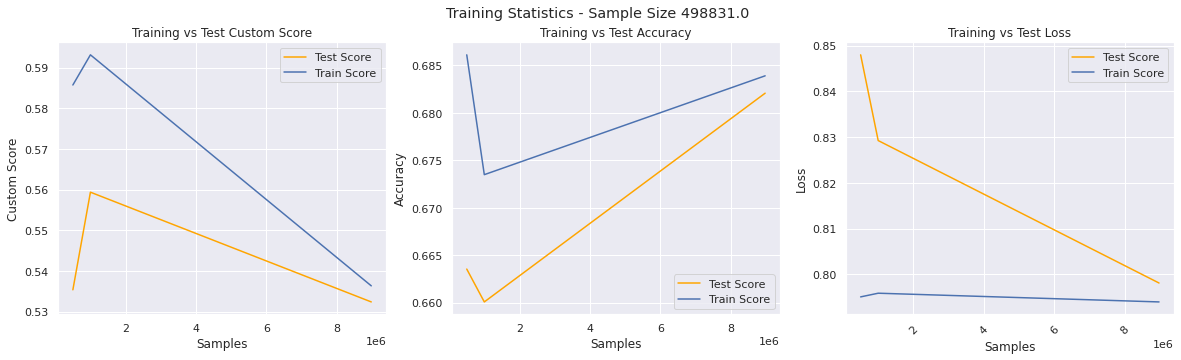

In [0]:
# for size in report_lstmb128_dr20_rdr20_batch128_lr01.sample_size:

#   stats_df = report_lstmb128_dr20_rdr20_batch128_lr01[report_lstmb128_dr20_rdr20_batch128_lr01.sample_size == size]
#   print(stats_df[["sample_size", "eval_metric", "accuracy", "loss"]])

f, a = plt.subplots(1, 3, figsize = (20, 5), sharex = True)
f.suptitle(f'Training Statistics - Sample Size {size}')

sns.lineplot(data = report_lstmb128_dr20_rdr20_batch128_lr01,
            x = "sample_size",
            y = "eval_metric",
            label = "Test Score",
            color = "orange",
            ax = a[0])
sns.lineplot(data = report_lstmb128_dr20_rdr20_batch128_lr01,
            x = "sample_size",
            y = "eval_metric_train",
            label = "Train Score",
            color = "b",
            ax = a[0])
_ = a[0].set_ylabel("Custom Score")
_ = a[0].set_xlabel("Samples")
_ = a[0].set_title("Training vs Test Custom Score")
_ = plt.xticks(rotation = 45)

sns.lineplot(data = report_lstmb128_dr20_rdr20_batch128_lr01,
            x = "sample_size",
            y = "accuracy",
            label = "Test Score",
            color = "orange",
            ax = a[1])
sns.lineplot(data = report_lstmb128_dr20_rdr20_batch128_lr01,
            x = "sample_size",
            y = "accuracy_train",
            label = "Train Score",
            color = "b",
            ax = a[1])
_ = a[1].set_ylabel("Accuracy")
_ = a[1].set_xlabel("Samples")
_ = a[1].set_title("Training vs Test Accuracy")
_ = plt.xticks(rotation = 45)

sns.lineplot(data = report_lstmb128_dr20_rdr20_batch128_lr01,
            x = "sample_size",
            y = "loss",
            label = "Test Score",
            color = "orange",
            ax = a[2])
sns.lineplot(data = report_lstmb128_dr20_rdr20_batch128_lr01,
            x = "sample_size",
            y = "loss_train",
            label = "Train Score",
            color = "b",
            ax = a[2])
_ = a[2].set_ylabel("Loss")
_ = a[2].set_xlabel("Samples")
_ = a[2].set_title("Training vs Test Loss")
_ = plt.xticks(rotation = 45)



# Network History For Various Sample Sizes

new version


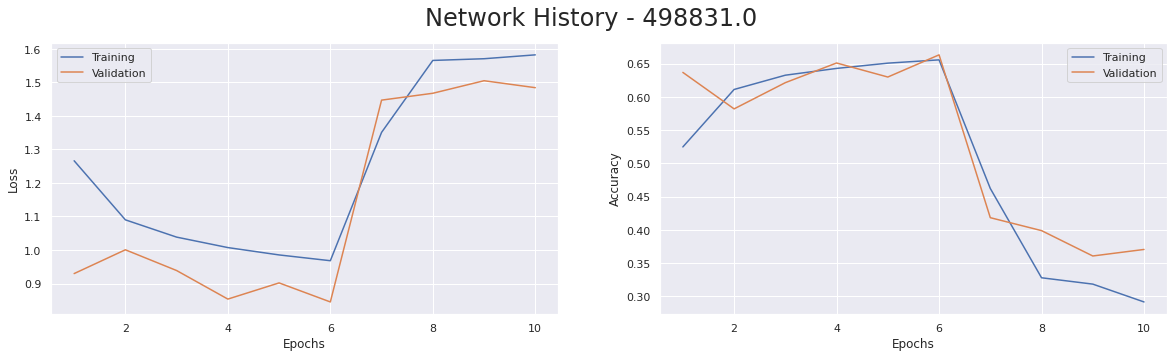

new version


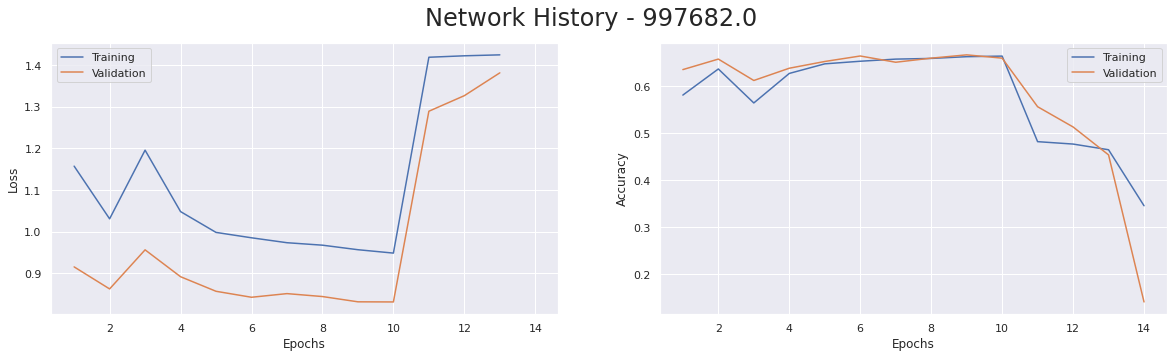

new version


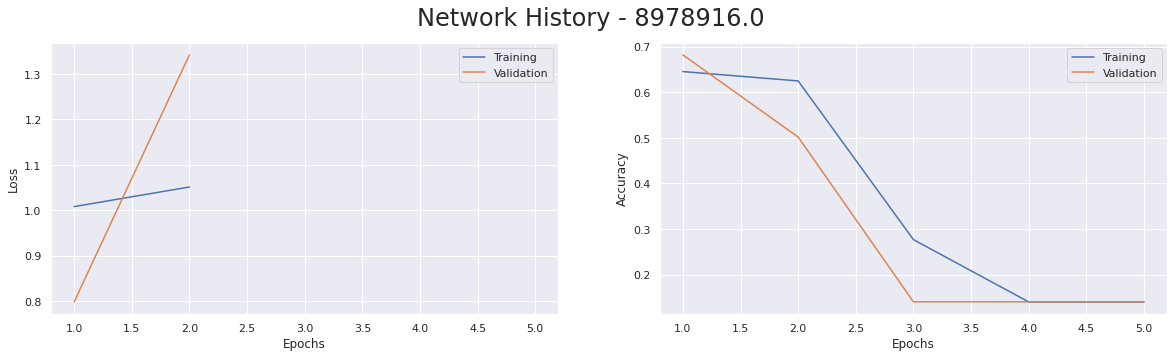

In [0]:
import importlib
importlib.reload(pu)

for size in report_lstmb128_dr20_rdr20_batch128_lr01.sample_size:
  report_lstmb128_dr20_rdr20_batch128_lr01_all = report_lstmb128_dr20_rdr20_batch128_lr01[report_lstmb128_dr20_rdr20_batch128_lr01.sample_size == size]
  with open(f'{REPORT_DIR}/{os.path.basename(report_lstmb128_dr20_rdr20_batch128_lr01_all.network_history_file.values[0])}', 'rb') as file:
    nh_all = pickle.load(file)

  pu.plot_network_history(nh_all, description = size, stored_history = True, figsize = (20, 5))